In [4]:
import numpy as np
import pandas as pd
import time
import psutil
import matplotlib.pyplot as plt
import warnings
import random
import openml
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder  
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from pmlb import fetch_data
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
import openml

# Define a function to preprocess data
def preprocess_data(X, preprocessor=None):
    if preprocessor is None:
        categorical_features = X.select_dtypes(include=['category', 'uint8']).columns
        numerical_features = X.select_dtypes(exclude= ['category','uint8']).columns

        transformers = []

        if not categorical_features.empty:
            categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')
            transformers.append(("categorical", categorical_transformer, categorical_features))

        if not numerical_features.empty:
            numerical_transformer = StandardScaler()
            transformers.append(("numerical", numerical_transformer, numerical_features))

        preprocessor = ColumnTransformer(transformers)

    X_preprocessed = preprocessor.fit_transform(X)
    X_preprocessed = pd.DataFrame(X_preprocessed, columns=preprocessor.get_feature_names_out())

    return X_preprocessed, preprocessor

# Get the dataset
def load_dataset():
    nomao = openml.datasets.get_dataset(1486)
    X, y, _, attribute_names = nomao.get_data(target=nomao.default_target_attribute)
    unique_labels = np.unique(y)
    print("Unique Labels:", unique_labels)
    return X, y, attribute_names

# Load the dataset
X, y, attribute_names = load_dataset()

# Print unique data types before preprocessing
print("\nUnique Data Types Before Preprocessing:")
print(X.dtypes.unique())

# Preprocess the entire dataset
X_preprocessed, preprocessor = preprocess_data(X)

# Print unique data types after preprocessing
print("\nUnique Data Types After Preprocessing:")
print(X_preprocessed.dtypes.unique())

# Define and fit the label encoder to the target variable
label_encoder = LabelEncoder()
label_encoder.fit(y)

# Shuffle the data before splitting into subsets
from sklearn.utils import shuffle
X_shuffled, y_shuffled = shuffle(X_preprocessed, y)

# Specify the sample sizes for subsets
sample_sizes = [5000, 10000, 15000, 20000, 25000, 30000, 34465]  # Add more sizes as needed

subsets = []
for size in sample_sizes:
    subset_train_size = int(size * 0.8)
    subset_test_size = size - subset_train_size

    # Stratified sampling to create balanced subsets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        X_shuffled, y_shuffled, train_size=subset_train_size, test_size=subset_test_size, stratify=y_shuffled, random_state=42)

    subsets.append((X_train_subset, y_train_subset, X_test_subset, y_test_subset))
    
# Print the class distribution for each subset
for i, (X_train_subset, y_train_subset, X_test_subset, y_test_subset) in enumerate(subsets):
    unique_classes_train, class_counts_train = np.unique(y_train_subset, return_counts=True)
    unique_classes_test, class_counts_test = np.unique(y_test_subset, return_counts=True)
    print(f"Subset {i+1} - Class Distribution:")
    print("Training Set:")
    for class_label, count in zip(unique_classes_train, class_counts_train):
        print(f"Class {class_label}: {count} samples")
    print("Test Set:")
    for class_label, count in zip(unique_classes_test, class_counts_test):
        print(f"Class {class_label}: {count} samples")
    print("-----------")

Unique Labels: ['1' '2']

Unique Data Types Before Preprocessing:
[dtype('float64') CategoricalDtype(categories=['1', '2'], ordered=True)
 CategoricalDtype(categories=['1', '2', '3'], ordered=True)]

Unique Data Types After Preprocessing:
[dtype('float64')]
Subset 1 - Class Distribution:
Training Set:
Class 1: 1142 samples
Class 2: 2858 samples
Test Set:
Class 1: 286 samples
Class 2: 714 samples
-----------
Subset 2 - Class Distribution:
Training Set:
Class 1: 2285 samples
Class 2: 5715 samples
Test Set:
Class 1: 571 samples
Class 2: 1429 samples
-----------
Subset 3 - Class Distribution:
Training Set:
Class 1: 3427 samples
Class 2: 8573 samples
Test Set:
Class 1: 857 samples
Class 2: 2143 samples
-----------
Subset 4 - Class Distribution:
Training Set:
Class 1: 4570 samples
Class 2: 11430 samples
Test Set:
Class 1: 1142 samples
Class 2: 2858 samples
-----------
Subset 5 - Class Distribution:
Training Set:
Class 1: 5712 samples
Class 2: 14288 samples
Test Set:
Class 1: 1428 samples
Cla

In [6]:
#used for nomao dataset
import psutil
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.metrics import accuracy_score

def evaluate_model(model, X_train, y_train, X_test, y_test, num_runs=5):

    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    avg_training_time = 0
    avg_cpu_usage = 0
    avg_memory_usage = 0
    avg_train_accuracy = 0
    avg_test_accuracy = 0
    avg_predicting_time = 0

    for _ in range(num_runs):
        # Start measuring CPU and memory usage
        process = psutil.Process()
        start_cpu = process.cpu_percent(interval=None)
        #start_memory = process.memory_info().rss / (1024 * 1024)

        # Perform cross-validation
        start_time = time.time()
        model.fit(X_train, y_train)
        #history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose= 0, callbacks=[early_stopping])
        training_time = time.time() - start_time

        # Measure CPU and memory usage
        final_cpu = max(0, process.cpu_percent(interval=None))
        
        # Calculate the change in CPU and memory usage
        cpu_usage = max(0, final_cpu - start_cpu)
        memory_usage = max(0, process.memory_info().rss / (1024 * 1024))
        
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)

        # Evaluate on test set
        start_time = time.time()
        y_test_pred = model.predict(X_test)
        predicting_time = time.time() - start_time
        
       # Calculate accuracy using predicted probabilities
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Update average values
        avg_training_time += training_time
        avg_cpu_usage += cpu_usage
        avg_memory_usage += memory_usage
        avg_train_accuracy += train_accuracy
        avg_test_accuracy += test_accuracy
        avg_predicting_time += predicting_time

    # Calculate average values
    avg_training_time /= num_runs
    avg_cpu_usage /= num_runs
    avg_memory_usage /= num_runs
    avg_train_accuracy /= num_runs
    avg_test_accuracy /= num_runs
    avg_predicting_time /= num_runs

    return avg_train_accuracy, avg_test_accuracy, avg_training_time, avg_predicting_time, avg_memory_usage, avg_cpu_usage

In [8]:
import csv
from sklearn.svm import SVC

svm_train_accuracies = []
svm_test_accuracies = []
svm_training_times = []
svm_predicting_times = []
svm_cpu_usages = []
svm_memory_usages = []
#SVM
best_svm = SVC(kernel = 'rbf', gamma = 0.01, degree = 3, C = 11.0)

# Perform initial randomized search cross-validation
'''start_time = time.time()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]
}
random_search_svm = RandomizedSearchCV(svm, param_distributions=param_grid, n_iter=30, cv=3, scoring='accuracy')
random_search_svm.fit(X_train_subset, y_train_subset)
end_time = time.time()

# Calculate the time taken for the initial search
initial_search_time_svm = end_time - start_time

# Get the best SVM model from the initial random search
best_svm_initial = random_search_svm.best_estimator_

# Perform refined search on the best SVM model
refined_param_grid = {
    'C': [best_svm_initial.C * 0.9, best_svm_initial.C, best_svm_initial.C* 1.1],
    'gamma': [best_svm_initial.gamma * 0.9, best_svm_initial.gamma, best_svm_initial.gamma * 1.1],
    'kernel': [best_svm_initial.kernel],
    'degree': [best_svm_initial.degree]
}
refined_search_svm = RandomizedSearchCV(svm, param_distributions=refined_param_grid, n_iter=10, cv=3, scoring='accuracy')
refined_search_svm.fit(X_train_subset, y_train_subset)

# Get the best SVM model from the refined search
best_svm_refined = refined_search_svm.best_estimator_


# Compare the performance of the initial and refined models
initial_accuracy_svm = random_search_svm.best_score_
refined_accuracy_svm = refined_search_svm.best_score_

# Determine which model to use for predictions based on performance
if refined_accuracy_svm > initial_accuracy_svm:
    print("The refined search produced a better result.")
    best_svm = best_svm_refined
else:
    print("The initial search produced a better result.")
    best_svm = best_svm_initial
    
# Print the results
print("Initial Accuracy SVM:", initial_accuracy_svm)
print("Refined Accuracy SVM:", refined_accuracy_svm)
# Print the best parameters obtained from the random search
print("Best parameters from initial search:", random_search_svm.best_params_)
print("Best parameters from refined search:", refined_search_svm.best_params_)
print("Initial Search Time:", initial_search_time_svm)
#print("Refined Search Time:", refined_search_time_rf)'''

for i, (X_train_subset, y_train_subset, X_test_subset, y_test_subset) in enumerate(subsets):

    # Use the best SVM model for evaluation
    svm_train_accuracy, svm_test_accuracy, svm_training_time, svm_predicting_time, svm_memory_usage, svm_cpu_usage = evaluate_model(best_svm, X_train_subset, y_train_subset,X_test_subset, y_test_subset)
    
    
    # Write the results to the CSV file
   # csv_writer.writerow(['1486', 'SVM', svm_accuracy, svm_test_accuracy, svm_training_time, svm_predicting_time, svm_memory_usage, svm_cpu_usage])
    
    svm_train_accuracies.append(svm_train_accuracy)
    svm_test_accuracies.append(svm_test_accuracy)
    svm_training_times.append(svm_training_time)
    svm_predicting_times.append(svm_predicting_time)
    svm_cpu_usages.append(svm_cpu_usage)
    svm_memory_usages.append(svm_memory_usage)
    
    
    # Print the average performance metrics
    subset_train_size = len(X_train_subset)
    subset_test_size = len(X_test_subset)
    subset_size = subset_train_size + subset_test_size
    print(f"Subset Size: {subset_size}")
    # Print the subset information and performance metrics
    print(f"Subset {i+1} - Performance Metrics:")
    print("Accuracy:", svm_train_accuracy)
    print("Test Accuracy:", svm_test_accuracy)
    print("Training Time:", svm_training_time)
    print("Predicting time:", svm_predicting_time)
    print("Memory Usage:", svm_memory_usage)
    print("CPU Usage:", svm_cpu_usage)
    print("---------------------------------")
#results_file.close()

Subset Size: 5000
Subset 1 - Performance Metrics:
Accuracy: 0.9845
Test Accuracy: 0.943
Training Time: 0.20382814407348632
Predicting time: 0.09596385955810546
Memory Usage: 775.16015625
CPU Usage: 98.56
---------------------------------
Subset Size: 10000
Subset 2 - Performance Metrics:
Accuracy: 0.9817500000000001
Test Accuracy: 0.953
Training Time: 1.0316616535186767
Predicting time: 0.3850058078765869
Memory Usage: 775.9328125
CPU Usage: 100.02000000000001
---------------------------------
Subset Size: 15000
Subset 3 - Performance Metrics:
Accuracy: 0.9796666666666667
Test Accuracy: 0.9586666666666666
Training Time: 3.1321808338165282
Predicting time: 0.9066627502441407
Memory Usage: 777.04609375
CPU Usage: 99.9
---------------------------------
Subset Size: 20000
Subset 4 - Performance Metrics:
Accuracy: 0.9804375000000001
Test Accuracy: 0.9655000000000001
Training Time: 5.956523704528808
Predicting time: 1.71318359375
Memory Usage: 785.08359375
CPU Usage: 99.14
------------------

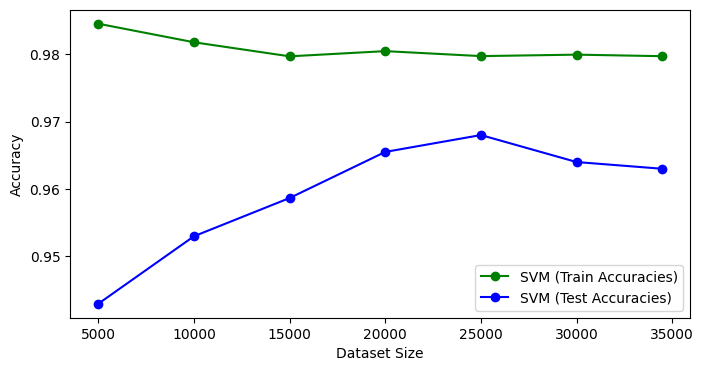

In [9]:
dataset_sizes = [5000, 10000, 15000, 20000, 25000, 30000, 34465]

plt.figure(figsize=(8, 4))  # Adjust the figure size to accommodate both plots side by side

# Plot RF accuracies
plt.plot(dataset_sizes, svm_train_accuracies, 'g-o', label='SVM (Train Accuracies)')

# Plot RF test accuracies 
plt.plot(dataset_sizes, svm_test_accuracies, 'b-o', label='SVM (Test Accuracies)')

plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

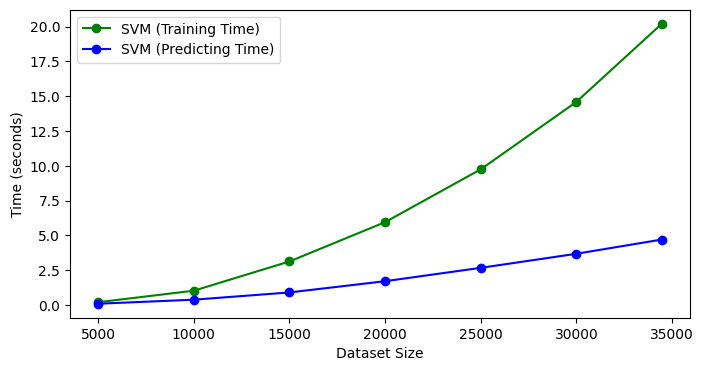

In [10]:
dataset_sizes = [5000, 10000, 15000, 20000, 25000, 30000, 34465]

plt.figure(figsize=(8, 4))

# Plot RF training times
plt.plot(dataset_sizes, svm_training_times, 'g-o', label='SVM (Training Time)')

# Plot RF predicting times 
plt.plot(dataset_sizes, svm_predicting_times, 'b-o', label='SVM (Predicting Time)')

plt.xlabel('Dataset Size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

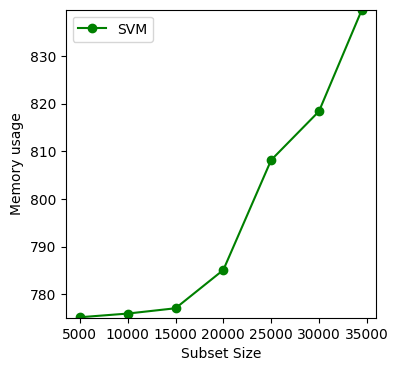

In [41]:
dataset_sizes = [5000, 10000, 15000, 20000, 25000, 30000, 34465]
# Plotting accuracy for SVM, RF, and NN
plt.figure(figsize=(4, 4))
plt.plot(dataset_sizes, svm_memory_usages, 'g-o', label='SVM')
plt.xlabel('Subset Size')  
y_lower = min(svm_memory_usages) - 0.1   # Adjust y-axis limits
y_upper = max(svm_memory_usages) + 0.1
plt.ylim(y_lower, y_upper)
plt.ylabel('Memory usage')
plt.legend()
plt.show()

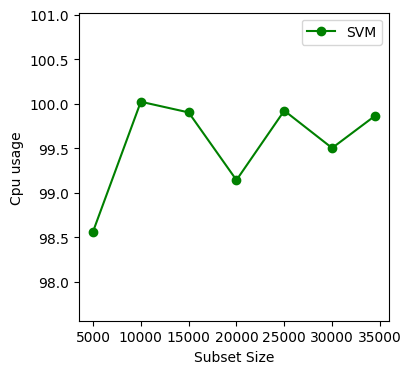

In [42]:
dataset_sizes = [5000, 10000, 15000, 20000, 25000, 30000, 34465]
# Plotting accuracy for SVM, RF, and NN
plt.figure(figsize=(4, 4))
plt.plot(dataset_sizes, svm_cpu_usages, 'g-o', label='SVM')
plt.xlabel('Subset Size')
plt.ylim(min(svm_cpu_usages) - 1, max(svm_cpu_usages) + 1)  # Adjust y-axis limits
plt.ylabel('Cpu usage')
plt.legend()
plt.show()

In [13]:
#RF

In [45]:
import csv
from sklearn.model_selection import cross_val_score, GridSearchCV
import sys
from sklearn.ensemble import RandomForestClassifier

rf_train_accuracies = []
rf_test_accuracies = []
rf_training_times = []
rf_predicting_times = []
rf_cpu_usages = []
rf_memory_usages = []

# Random Forest (RF)
#np.random.seed(42)
best_rf = RandomForestClassifier(n_jobs=-1, n_estimators = 500, max_depth = 25)

# Perform initial randomized search cross-validation
'''start_time = time.time()
rf_param_grid = {'n_estimators': [100, 200, 300, 400, 500, 600], 'max_depth': [5, 10, 15, 20, 25]}
rf_random_search = RandomizedSearchCV(rf, param_distributions=rf_param_grid, n_iter=30, cv=3, scoring='accuracy', n_jobs=-1)
rf_random_search.fit(X_train_subset, y_train_subset)
end_time = time.time()

# Calculate the time taken for the initial search
initial_search_time_rf = end_time - start_time

# Get the best RF model from the random search
best_rf_initial = rf_random_search.best_estimator_


# Define refined parameter grid using the best RF model from the random search
refined_param_grid_rf = {
    'n_estimators': [best_rf_initial.n_estimators - 50, best_rf_initial.n_estimators, best_rf_initial.n_estimators + 50],
    'max_depth': [best_rf_initial.max_depth - 3, best_rf_initial.max_depth, best_rf_initial.max_depth + 3]
}

# Perform refined randomized search cross-validation using the same hyperparameters
start_time = time.time()
#refined_grid_search_rf = GridSearchCV(rf, param_grid=refined_param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
refined_random_search_rf = RandomizedSearchCV(rf, param_distributions=refined_param_grid_rf, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1)
refined_random_search_rf.fit(X_train_subset, y_train_subset)
end_time = time.time()

# Calculate the time taken for the refined search
refined_search_time_rf = end_time - start_time

# Get the best RF model from the refined search
best_rf_refined = refined_random_search_rf.best_estimator_

# Compare the performance of the initial and refined models
initial_accuracy_rf = rf_random_search.best_score_
refined_accuracy_rf = refined_random_search_rf.best_score_

# Determine which model to use for predictions based on performance
if refined_accuracy_rf > initial_accuracy_rf:
    print("The refined search produced a better result.")
    best_rf = best_rf_refined
else:
    print("The initial search produced a better result.")
    best_rf = best_rf_initial
    
# Print the results
print("Initial Accuracy RF:", initial_accuracy_rf)
print("Refined Accuracy RF:", refined_accuracy_rf)
# Print the best parameters obtained from the random search
print("Best parameters from random search:",rf_random_search.best_params_)
# Print the best parameters obtained from the refined search
print("Best parameters from refined search:",refined_random_search_rf.best_params_)
# Print the time taken for the initial and refined searches
print("Initial Search Time:", initial_search_time_rf)
print("Refined Search Time:", refined_search_time_rf)'''

for i, (X_train_subset, y_train_subset, X_test_subset, y_test_subset) in enumerate(subsets):
    # Use the best RF model for evaluation
    rf_train_accuracy, rf_test_accuracy, rf_training_time, rf_predicting_time, rf_memory_usage, rf_cpu_usage = evaluate_model(best_rf, X_train_subset, y_train_subset, X_test_subset, y_test_subset)
    
    
    # Write the results to the CSV file
    #csv_writer.writerow(['1486','RF', rf_accuracy, avg_rf_test_accuracy, rf_training_time, rf_predicting_time, rf_memory_usage, rf_cpu_usage])
    
    rf_train_accuracies.append(rf_train_accuracy)
    rf_test_accuracies.append(rf_test_accuracy)
    rf_training_times.append(rf_training_time)
    rf_predicting_times.append(rf_predicting_time)
    rf_cpu_usages.append(rf_cpu_usage)
    rf_memory_usages.append(rf_memory_usage)
    
    # Print the average performance metrics
    subset_train_size = len(X_train_subset)
    subset_test_size = len(X_test_subset)
    subset_size = subset_train_size + subset_test_size
    print(f"Subset Size: {subset_size}")
    # Print the subset information and performance metrics
    print(f"Subset {i+1} - Performance Metrics:")
    print("Accuracy:", rf_train_accuracy)
    print("Test Accuracy:", rf_test_accuracy)
    print("Training Time:", rf_training_time)
    print("Predicting time:", rf_predicting_time)
    print("Memory Usage:", rf_memory_usage)
    print("CPU Usage:", rf_cpu_usage)
    print("---------------------------------")
#results_file.close()   

Subset Size: 5000
Subset 1 - Performance Metrics:
Accuracy: 1.0
Test Accuracy: 0.96
Training Time: 2.712170648574829
Predicting time: 0.21306591033935546
Memory Usage: 775.53515625
CPU Usage: 456.7
---------------------------------
Subset Size: 10000
Subset 2 - Performance Metrics:
Accuracy: 1.0
Test Accuracy: 0.9625999999999999
Training Time: 4.6492164611816404
Predicting time: 0.29418220520019533
Memory Usage: 794.596875
CPU Usage: 523.6600000000001
---------------------------------
Subset Size: 15000
Subset 3 - Performance Metrics:
Accuracy: 1.0
Test Accuracy: 0.961
Training Time: 6.847834682464599
Predicting time: 0.3539910316467285
Memory Usage: 809.81484375
CPU Usage: 547.58
---------------------------------
Subset Size: 20000
Subset 4 - Performance Metrics:
Accuracy: 1.0
Test Accuracy: 0.9650000000000001
Training Time: 9.244905424118041
Predicting time: 0.39200625419616697
Memory Usage: 820.6484375
CPU Usage: 561.34
---------------------------------
Subset Size: 25000
Subset 5 -

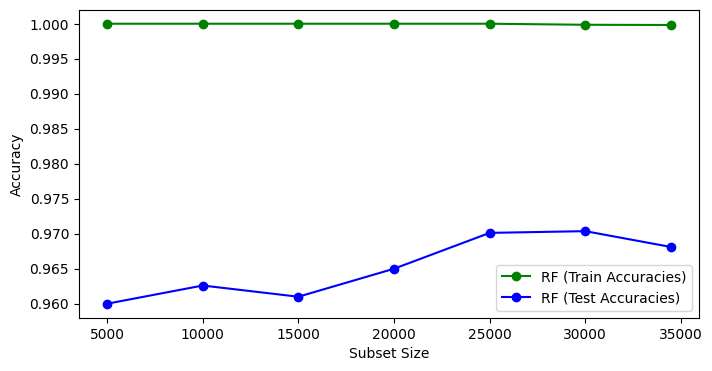

In [49]:
import matplotlib.pyplot as plt

dataset_sizes = [5000, 10000, 15000, 20000, 25000, 30000, 34465]

plt.figure(figsize=(8, 4))  # Adjust the figure size to accommodate both plots side by side

# Plot RF accuracies
plt.plot(dataset_sizes, rf_train_accuracies, 'g-o', label='RF (Train Accuracies)')

# Plot RF test accuracies 
plt.plot(dataset_sizes, rf_test_accuracies, 'b-o', label='RF (Test Accuracies)')

plt.xlabel('Subset Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

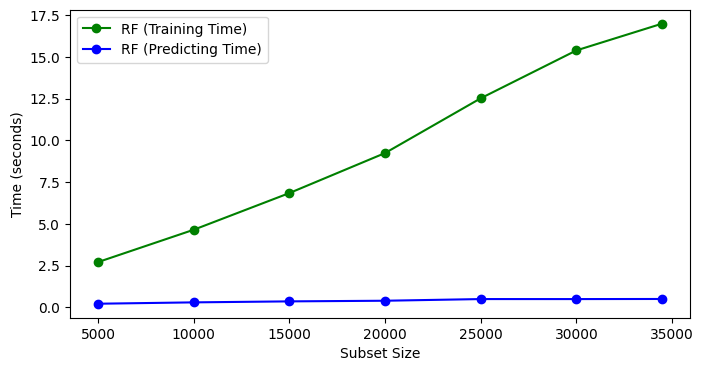

In [48]:
plt.figure(figsize=(8, 4))

# Plot RF training times
plt.plot(dataset_sizes, rf_training_times, 'g-o', label='RF (Training Time)')

# Plot RF predicting times 
plt.plot(dataset_sizes, rf_predicting_times, 'b-o', label='RF (Predicting Time)')

plt.xlabel('Subset Size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

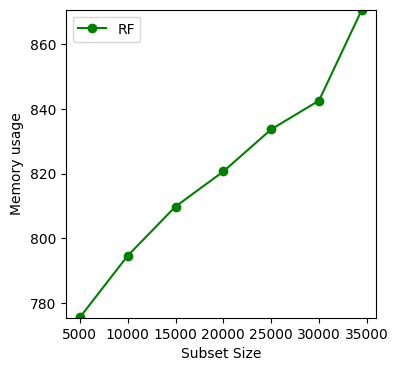

In [47]:
# Plotting accuracy for SVM, RF, and NN
plt.figure(figsize=(4, 4))
plt.plot(dataset_sizes, rf_memory_usages, 'g-o', label='RF')
plt.xlabel('Subset Size')  
y_lower = min(rf_memory_usages) - 0.1   # Adjust y-axis limits
y_upper = max(rf_memory_usages) + 0.1
plt.ylim(y_lower, y_upper)
plt.ylabel('Memory usage')
plt.legend()
plt.show()

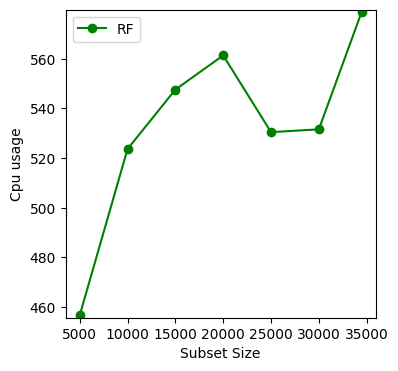

In [46]:
# Plotting accuracy for SVM, RF, and NN
plt.figure(figsize=(4, 4))
plt.plot(dataset_sizes, rf_cpu_usages, 'g-o', label='RF')
plt.xlabel('Subset Size')
plt.ylim(min(rf_cpu_usages) - 1, max(rf_cpu_usages) + 1)  # Adjust y-axis limits
plt.ylabel('Cpu usage')
plt.legend()
plt.show()

In [15]:
#NN

In [20]:
import csv
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.neural_network import MLPClassifier

nn_train_accuracies = []
nn_test_accuracies = []
nn_training_times = []
nn_predicting_times = []
nn_cpu_usages = []
nn_memory_usages = []


# Neural Network (NN)
best_nn = MLPClassifier(early_stopping=True, max_iter = 400, hidden_layer_sizes = (100,))

'''param_grid = {
    'hidden_layer_sizes': [(80,), (100,), (50, 50), (50, 50, 50), (100, 100), (200, 200)],
    'max_iter' : [100, 200, 300, 400, 500]
             }

# Perform initial randomized search cross-validation
start_time = time.time()
random_search_nn = RandomizedSearchCV(nn, param_distributions=param_grid, n_iter=30, cv=3, scoring='accuracy')
random_search_nn.fit(X_train_subset, y_train_subset)
end_time = time.time()
        
#Calculate the time taken for the initial search
initial_search_time_nn = end_time - start_time

# Get the best NN model from the initial random search
best_nn_initial = random_search_nn.best_estimator_
# Retrieve the parameter values from the best_nn_initial model
best_params_nn_initial = best_nn_initial.get_params()

# Analyze the initial search results and narrow down the parameter space
# Modify the param_grid based on the analysis to define a refined parameter space

# Define the range or values to explore around the best parameters
refined_param_grid_nn = {
        'hidden_layer_sizes': [best_params_nn_initial['hidden_layer_sizes']],
        #'alpha': [best_nn_initial['alpha'], best_nn_initial['alpha'] * 0.1, best_nn_initial['alpha'] * 10],
        'max_iter': [best_params_nn_initial['max_iter'], best_params_nn_initial['max_iter'] + 50, best_params_nn_initial['max_iter'] + 100],
                        }
            
start_time = time.time()
refined_random_search_nn = RandomizedSearchCV(nn, param_distributions=refined_param_grid_nn, n_iter=10, cv=3, scoring='accuracy')
refined_random_search_nn.fit(X_train_subset, y_train_subset)
end_time = time.time()
        
# Calculate the time taken for the refined search
refined_search_time_nn = end_time - start_time

# Get the best NN model from the refined random search
best_nn_refined = refined_random_search_nn.best_estimator_
        
# Compare the performance of the initial and refined models
initial_accuracy_nn = random_search_nn.best_score_
refined_accuracy_nn= refined_random_search_nn.best_score_
        
# Determine which model to use for predictions based on performance
if refined_accuracy_nn > initial_accuracy_nn:
    print("The refined search produced a better result.")
    best_nn = best_nn_refined
else:
    print("The initial search produced a better result.")
    best_nn = best_nn_initial
    
# Print the results
print("Initial Accuracy NN:", initial_accuracy_nn)
print("Refined Accuracy NN:", refined_accuracy_nn)
# Print the best parameters obtained from the random search
print("Best parameters from initial search:", random_search_nn.best_params_)
# Print the best parameters obtained from the refined search
print("Best parameters from refined search:", refined_random_search_nn.best_params_)
# Print the time taken for the initial and refined searches
print("Initial Search Time:", initial_search_time_nn)
#print("Refined Search Time:", refined_search_time_rf)'''

for i, (X_train_subset, y_train_subset, X_test_subset, y_test_subset) in enumerate(subsets):

    # Use the best SVM model for evaluation
    nn_train_accuracy, nn_test_accuracy, nn_training_time, nn_predicting_time, nn_memory_usage, nn_cpu_usage = evaluate_model(best_nn, X_train_subset, y_train_subset,X_test_subset, y_test_subset)
    


    # Write the results to the CSV file
    #csv_writer.writerow([1486, 'NN', nn_accuracy, nn_test_accuracy, nn_training_time, nn_memory_usage, nn_cpu_usage])
        
    nn_train_accuracies.append(nn_train_accuracy)
    nn_test_accuracies.append(nn_test_accuracy)
    nn_training_times.append(nn_training_time)
    nn_predicting_times.append(nn_predicting_time)
    nn_cpu_usages.append(nn_cpu_usage)
    nn_memory_usages.append(nn_memory_usage)
        
       # Print the average performance metrics
    subset_train_size = len(X_train_subset)
    subset_test_size = len(X_test_subset)
    subset_size = subset_train_size + subset_test_size
    print(f"Subset Size: {subset_size}")
    # Print the subset information and performance metrics
    print(f"Subset {i+1} - Performance Metrics:")
    print("Accuracy:", nn_train_accuracy)
    print("Test Accuracy:", nn_test_accuracy)
    print("Training Time:", nn_training_time)
    print("Predicting time:", nn_predicting_time)
    print("Memory Usage:", nn_memory_usage)
    print("CPU Usage:", nn_cpu_usage)
    print("---------------------------------")
#results_file.close()

Subset Size: 5000
Subset 1 - Performance Metrics:
Accuracy: 0.9673999999999999
Test Accuracy: 0.9491999999999999
Training Time: 1.6173484802246094
Predicting time: 0.011810302734375
Memory Usage: 260.25703125
CPU Usage: 181.2
---------------------------------
Subset Size: 10000
Subset 2 - Performance Metrics:
Accuracy: 0.9631500000000001
Test Accuracy: 0.9513
Training Time: 2.4074375152587892
Predicting time: 0.0045203685760498045
Memory Usage: 278.1953125
CPU Usage: 192.42000000000002
---------------------------------
Subset Size: 15000
Subset 3 - Performance Metrics:
Accuracy: 0.9721
Test Accuracy: 0.9566666666666667
Training Time: 5.120092678070068
Predicting time: 0.011067485809326172
Memory Usage: 304.8796875
CPU Usage: 201.22
---------------------------------
Subset Size: 20000
Subset 4 - Performance Metrics:
Accuracy: 0.9677250000000001
Test Accuracy: 0.9571500000000001
Training Time: 4.5816600799560545
Predicting time: 0.010677576065063477
Memory Usage: 338.19140625
CPU Usage: 

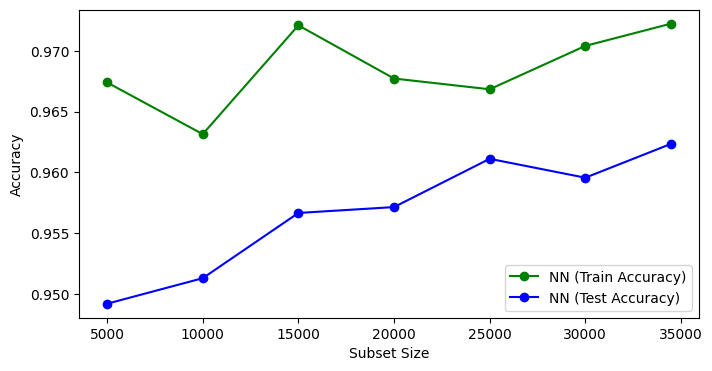

In [30]:
import matplotlib.pyplot as plt

dataset_sizes = [5000, 10000, 15000, 20000, 25000, 30000, 34465]

plt.figure(figsize=(8, 4))

# Plot RF training times
plt.plot(dataset_sizes, nn_train_accuracies, 'g-o', label='NN (Train Accuracy)')

# Plot RF predicting times 
plt.plot(dataset_sizes, nn_test_accuracies, 'b-o', label='NN (Test Accuracy)')

plt.xlabel('Subset Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

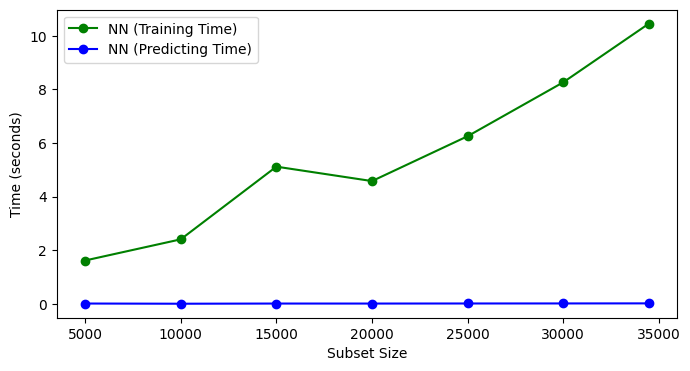

In [31]:
plt.figure(figsize=(8, 4))

# Plot RF training times
plt.plot(dataset_sizes, nn_training_times, 'g-o', label='NN (Training Time)')

# Plot RF predicting times 
plt.plot(dataset_sizes, nn_predicting_times, 'b-o', label='NN (Predicting Time)')

plt.xlabel('Subset Size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

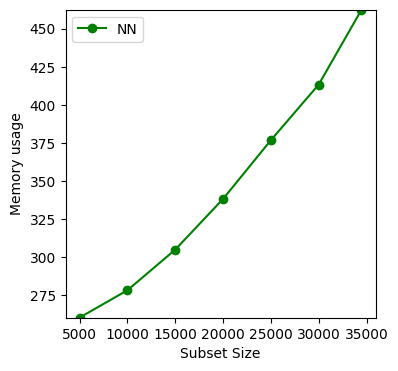

In [32]:
plt.figure(figsize=(4, 4))
plt.plot(dataset_sizes, nn_memory_usages, 'g-o', label='NN')
plt.xlabel('Subset Size')  
y_lower = min(nn_memory_usages) - 0.1   # Adjust y-axis limits
y_upper = max(nn_memory_usages) + 0.1
plt.ylim(y_lower, y_upper)
plt.ylabel('Memory usage')
plt.legend()
plt.show()

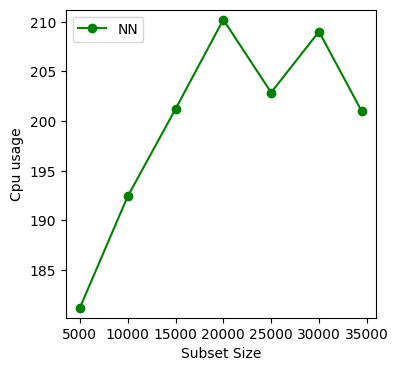

In [33]:
plt.figure(figsize=(4, 4))
plt.plot(dataset_sizes, nn_cpu_usages, 'g-o', label='NN')
plt.xlabel('Subset Size')
plt.ylim(min(nn_cpu_usages) - 1, max(nn_cpu_usages) + 1)  # Adjust y-axis limits
plt.ylabel('Cpu usage')
plt.legend()
plt.show()

In [34]:
#Comparison

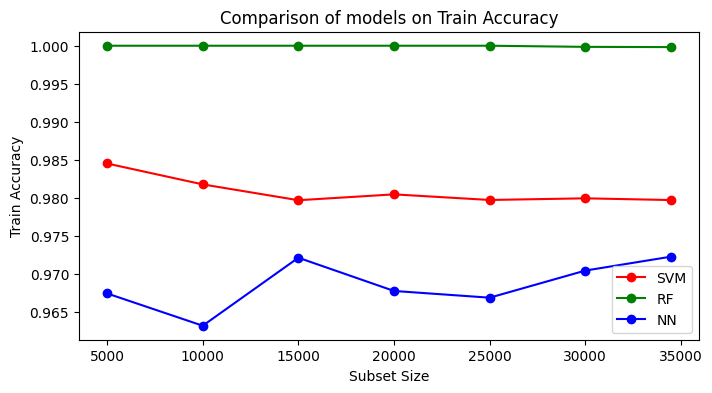

In [50]:
import matplotlib.pyplot as plt

# Plotting accuracy for SVM, RF, and NN in one plot
plt.figure(figsize=(8, 4))

# Plot for TensorFlow
plt.plot(dataset_sizes, svm_train_accuracies, 'r-o',label='SVM')

# Plot for scikit-learn
plt.plot(dataset_sizes, rf_train_accuracies, 'g-o', label='RF')

# Plot for scikit-learn
plt.plot(dataset_sizes, nn_train_accuracies, 'b-o',label='NN')


plt.xlabel('Subset Size')
plt.ylabel('Train Accuracy')
plt.title('Comparison of models on Train Accuracy')
plt.legend()

# Show the combined plot
plt.show()

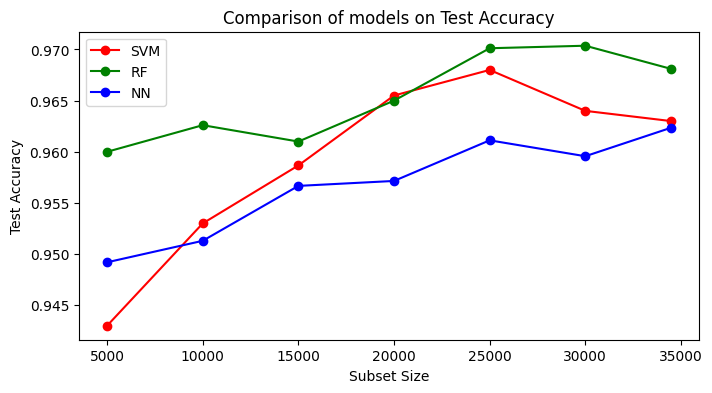

In [51]:
import matplotlib.pyplot as plt

# Assuming you have already defined the following variables:
# dataset_sizes, nn_tf_cpu_usages, nn_cpu_usages

# Plotting accuracy for SVM, RF, and NN in one plot
plt.figure(figsize=(8, 4))

# Plot for TensorFlow
plt.plot(dataset_sizes, svm_test_accuracies, 'r-o',label='SVM')

# Plot for scikit-learn
plt.plot(dataset_sizes, rf_test_accuracies, 'g-o', label='RF')

# Plot for scikit-learn
plt.plot(dataset_sizes, nn_test_accuracies, 'b-o',label='NN')


plt.xlabel('Subset Size')
plt.ylabel('Test Accuracy')
plt.title('Comparison of models on Test Accuracy')
plt.legend()

# Show the combined plot
plt.show()

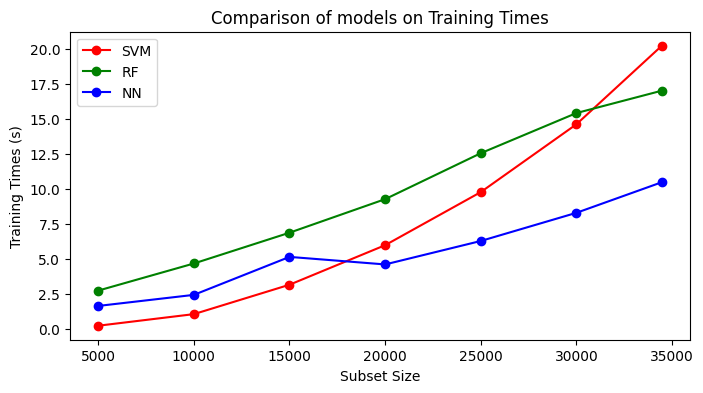

In [52]:
import matplotlib.pyplot as plt

# Assuming you have already defined the following variables:
# dataset_sizes, nn_tf_cpu_usages, nn_cpu_usages

# Plotting accuracy for SVM, RF, and NN in one plot
plt.figure(figsize=(8, 4))

# Plot for TensorFlow
plt.plot(dataset_sizes, svm_training_times, 'r-o',label='SVM')

# Plot for scikit-learn
plt.plot(dataset_sizes, rf_training_times, 'g-o', label='RF')

# Plot for scikit-learn
plt.plot(dataset_sizes, nn_training_times, 'b-o',label='NN')


plt.xlabel('Subset Size')
plt.ylabel('Training Times (s)')
plt.title('Comparison of models on Training Times')
plt.legend()

# Show the combined plot
plt.show()

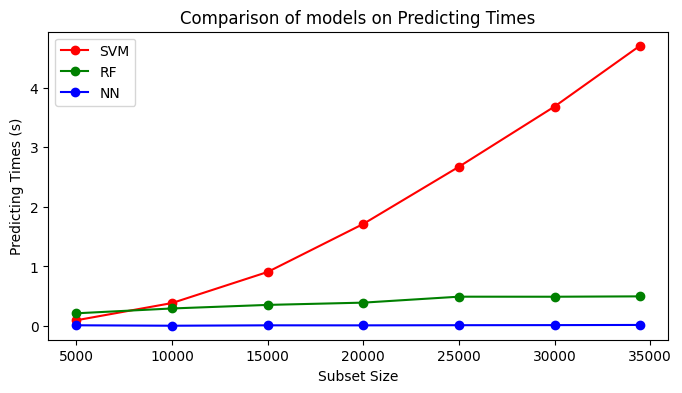

In [53]:
import matplotlib.pyplot as plt

# Assuming you have already defined the following variables:
# dataset_sizes, nn_tf_cpu_usages, nn_cpu_usages

# Plotting accuracy for SVM, RF, and NN in one plot
plt.figure(figsize=(8, 4))

# Plot for TensorFlow
plt.plot(dataset_sizes, svm_predicting_times, 'r-o',label='SVM')

# Plot for scikit-learn
plt.plot(dataset_sizes, rf_predicting_times, 'g-o', label='RF')

# Plot for scikit-learn
plt.plot(dataset_sizes, nn_predicting_times, 'b-o',label='NN')


plt.xlabel('Subset Size')
plt.ylabel('Predicting Times (s)')
plt.title('Comparison of models on Predicting Times')
plt.legend()

# Show the combined plot
plt.show()

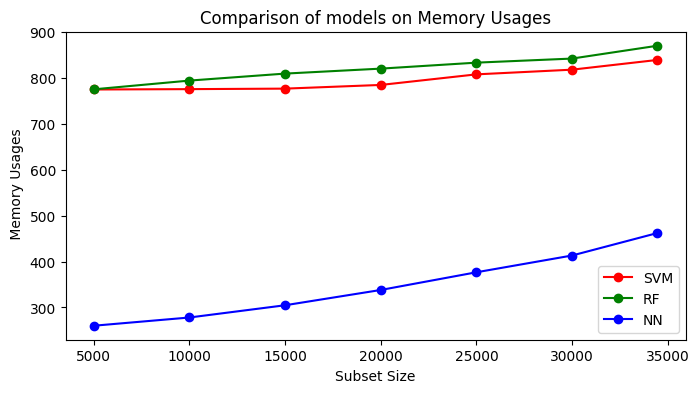

In [54]:
import matplotlib.pyplot as plt

# Assuming you have already defined the following variables:
# dataset_sizes, nn_tf_cpu_usages, nn_cpu_usages

# Plotting accuracy for SVM, RF, and NN in one plot
plt.figure(figsize=(8, 4))

# Plot for TensorFlow
plt.plot(dataset_sizes, svm_memory_usages, 'r-o',label='SVM')

# Plot for scikit-learn
plt.plot(dataset_sizes, rf_memory_usages, 'g-o', label='RF')

# Plot for scikit-learn
plt.plot(dataset_sizes, nn_memory_usages, 'b-o',label='NN')


plt.xlabel('Subset Size')
plt.ylabel(' Memory Usages')
plt.title('Comparison of models on Memory Usages')
plt.legend()

# Show the combined plot
plt.show()

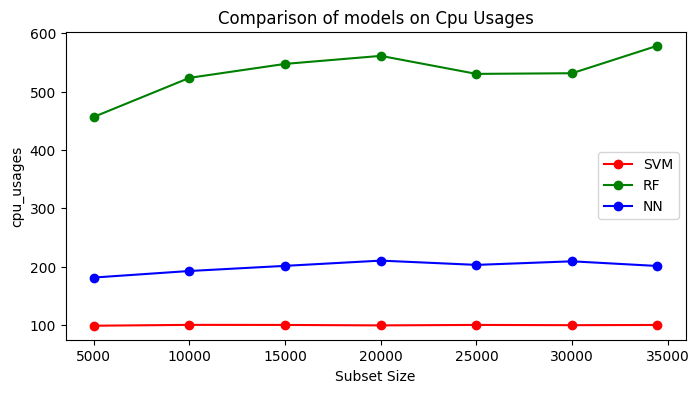

In [55]:
import matplotlib.pyplot as plt

# Assuming you have already defined the following variables:
# dataset_sizes, nn_tf_cpu_usages, nn_cpu_usages

# Plotting accuracy for SVM, RF, and NN in one plot
plt.figure(figsize=(8, 4))

# Plot for TensorFlow
plt.plot(dataset_sizes, svm_cpu_usages, 'r-o',label='SVM')

# Plot for scikit-learn
plt.plot(dataset_sizes, rf_cpu_usages, 'g-o', label='RF')

# Plot for scikit-learn
plt.plot(dataset_sizes, nn_cpu_usages, 'b-o',label='NN')


plt.xlabel('Subset Size')
plt.ylabel('cpu_usages')
plt.title('Comparison of models on Cpu Usages')
plt.legend()

# Show the combined plot
plt.show()